<a href="https://colab.research.google.com/github/Akash-nitA/elastic-weight-consolidation/blob/main/continual_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
cond=y_train==0
taskA={'data':x_train[cond],'label':y_train[cond]}
cond=y_train==1
taskB={'data':x_train[cond],'label':y_train[cond]}
cond=y_train==2
taskC={'data':x_train[cond],'label':y_train[cond]}

In [4]:
def model():
    l1=tf.keras.layers.Flatten(input_shape=(28,28))
    l2=tf.keras.layers.Dense(10,activation='softmax')
    mod=tf.keras.Sequential([l1,l2])
    mod.compile(loss='SparseCategoricalCrossentropy',optimizer='adam',metrics=['accuracy'])
    return mod
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.accA=[]
        self.accB=[]

    
    def on_epoch_end(self,epoch,logs=None):
        self.accB.append(logs['accuracy'])
        self.accA.append(logs['val_accuracy'])
        if logs['accuracy']==1.0:
            self.model.stop_training=1

class CustomCallback2(tf.keras.callbacks.Callback):
    def __init__(self):
        self.accB=[]
        self.accC=[]

    
    def on_epoch_end(self,epoch,logs=None):
        self.accC.append(logs['accuracy'])
        self.accB.append(logs['val_accuracy'])
        if logs['accuracy']==1.0:
            self.model.stop_training=1

nn=model()
        

In [5]:
nn.fit(taskA['data']/255.0,taskA['label'],epochs=10)

Epoch 1/10
186/186 [==============================] - 5s 4ms/step - loss: 0.1847 - accuracy: 0.9613
Epoch 2/10
186/186 [==============================] - 1s 4ms/step - loss: 0.0069 - accuracy: 1.0000
Epoch 3/10
186/186 [==============================] - 1s 4ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 4/10
186/186 [==============================] - 1s 4ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 5/10
186/186 [==============================] - 1s 5ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 6/10
186/186 [==============================] - 1s 4ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 7/10
186/186 [==============================] - 1s 4ms/step - loss: 8.7330e-04 - accuracy: 1.0000
Epoch 8/10
186/186 [==============================] - 1s 4ms/step - loss: 6.9947e-04 - accuracy: 1.0000
Epoch 9/10
186/186 [==============================] - 1s 4ms/step - loss: 5.7293e-04 - accuracy: 1.0000
Epoch 10/10
186/186 [==============================] - 1s 4ms/step - loss: 4.7738e-04 - 

In [6]:
theta=nn.weights
theta

[<tf.Variable 'dense/kernel:0' shape=(784, 10) dtype=float32, numpy=
 array([[-0.07263309, -0.00357434,  0.08506728, ..., -0.08022805,
          0.01846791,  0.00564793],
        [-0.06393027,  0.08240461, -0.00510672, ..., -0.01628317,
         -0.00872043,  0.02816109],
        [ 0.07678702, -0.02042364,  0.05511581, ...,  0.03954514,
         -0.07369772, -0.02760988],
        ...,
        [-0.027466  , -0.07193014, -0.04925219, ...,  0.02212696,
         -0.02597134,  0.0367496 ],
        [ 0.03230736,  0.06974704,  0.02959953, ..., -0.06620262,
          0.03765327,  0.02768303],
        [-0.00743025,  0.07197589, -0.04122144, ..., -0.05229333,
          0.07656575, -0.0335294 ]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(10,) dtype=float32, numpy=
 array([ 0.06930827, -0.072441  , -0.0681812 , -0.06684165, -0.06965578,
        -0.07107584, -0.06925656, -0.06951419, -0.07150263, -0.06918786],
       dtype=float32)>]

In [7]:
theta_star=nn.get_weights()
theta_star

[array([[-0.07263309, -0.00357434,  0.08506728, ..., -0.08022805,
          0.01846791,  0.00564793],
        [-0.06393027,  0.08240461, -0.00510672, ..., -0.01628317,
         -0.00872043,  0.02816109],
        [ 0.07678702, -0.02042364,  0.05511581, ...,  0.03954514,
         -0.07369772, -0.02760988],
        ...,
        [-0.027466  , -0.07193014, -0.04925219, ...,  0.02212696,
         -0.02597134,  0.0367496 ],
        [ 0.03230736,  0.06974704,  0.02959953, ..., -0.06620262,
          0.03765327,  0.02768303],
        [-0.00743025,  0.07197589, -0.04122144, ..., -0.05229333,
          0.07656575, -0.0335294 ]], dtype=float32),
 array([ 0.06930827, -0.072441  , -0.0681812 , -0.06684165, -0.06965578,
        -0.07107584, -0.06925656, -0.06951419, -0.07150263, -0.06918786],
       dtype=float32)]

In [8]:
lam=5
def compute_fisher(tasks):
    fisher=[np.zeros(v.get_shape().as_list())     for v in theta]
    count=0
    for data in tasks:
        count+=len(data)//20
        for i in range(len(data)//20):
            d=tf.reshape(data[i],(1,28,28))
            with tf.GradientTape() as g:
                g.watch(theta)
                probs=nn(d)
                y=tf.math.log(probs)
            ders=g.gradient(y,theta)
            for v in range(len(fisher)):
                fisher[v]+=tf.square(ders[v])
    for v in range(len(fisher)):
        fisher[v]/=count
    return fisher            

fisher=compute_fisher([taskA['data']/255])
fisher

[<tf.Tensor: shape=(784, 10), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([80.92527   ,  0.99929583,  0.9990681 ,  0.9985791 ,  0.9990624 ,
         0.9993902 ,  0.99900687,  0.99897623,  0.99922705,  0.99909765],
       dtype=float32)>]

In [9]:
@tf.function
def custom_loss(y_true,y_pred):
    loss=tf.keras.losses.sparse_categorical_crossentropy(y_true,y_pred)
    for v in range(len(theta)):
        loss+=(lam/2)*tf.reduce_sum(tf.multiply(fisher[v],tf.square(theta[v]-theta_star[v])))
    return loss
nn.compile(loss=custom_loss,optimizer='adam',metrics=['accuracy'])


In [10]:
nn.evaluate(taskA['data']/255.0,taskA['label'])

186/186 [==============================] - 2s 4ms/step - loss: 4.3723e-04 - accuracy: 1.0000


[0.0004372271941974759, 1.0]

211/211 [==============================] - 1s 3ms/step - loss: 6.2011 - accuracy: 0.0000e+00
Epoch 1/10
211/211 [==============================] - 2s 4ms/step - loss: 2.4188 - accuracy: 0.4132 - val_loss: 0.6881 - val_accuracy: 1.0000
Epoch 2/10
211/211 [==============================] - 1s 6ms/step - loss: 0.9142 - accuracy: 0.9131 - val_loss: 0.4499 - val_accuracy: 1.0000
Epoch 3/10
211/211 [==============================] - 1s 6ms/step - loss: 0.6405 - accuracy: 0.9494 - val_loss: 0.3511 - val_accuracy: 1.0000
Epoch 4/10
211/211 [==============================] - 1s 4ms/step - loss: 0.5134 - accuracy: 0.9594 - val_loss: 0.3007 - val_accuracy: 1.0000
Epoch 5/10
211/211 [==============================] - 1s 4ms/step - loss: 0.4400 - accuracy: 0.9668 - val_loss: 0.2617 - val_accuracy: 1.0000
Epoch 6/10
211/211 [==============================] - 1s 6ms/step - loss: 0.3918 - accuracy: 0.9703 - val_loss: 0.2360 - val_accuracy: 0.9998
Epoch 7/10
211/211 [==============================] - 1

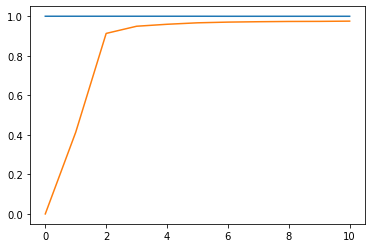

In [11]:
cb=CustomCallback()
accA=[]
accB=[]
accA.append(nn.evaluate(taskA['data']/255.0,taskA['label'])[1])
accB.append(nn.evaluate(taskB['data']/255.0,taskB['label'])[1])
nn.fit(taskB['data']/255.0,taskB['label'],epochs=10,validation_data=(taskA['data']/255.0,taskA['label']),callbacks=[cb])
accA+=cb.accA
accB+=cb.accB
plt.plot(accA)
plt.plot(accB)
plt.show()

In [12]:
theta=nn.weights
theta_star=nn.get_weights()
theta

[<tf.Variable 'dense/kernel:0' shape=(784, 10) dtype=float32, numpy=
 array([[-0.07263309, -0.00357434,  0.08506728, ..., -0.08022805,
          0.01846791,  0.00564793],
        [-0.06393027,  0.08240461, -0.00510672, ..., -0.01628317,
         -0.00872043,  0.02816109],
        [ 0.07678702, -0.02042364,  0.05511581, ...,  0.03954514,
         -0.07369772, -0.02760988],
        ...,
        [-0.027466  , -0.07193014, -0.04925219, ...,  0.02212696,
         -0.02597134,  0.0367496 ],
        [ 0.03230736,  0.06974704,  0.02959953, ..., -0.06620262,
          0.03765327,  0.02768303],
        [-0.00743025,  0.07197589, -0.04122144, ..., -0.05229333,
          0.07656575, -0.0335294 ]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(10,) dtype=float32, numpy=
 array([ 0.06916437, -0.05985205, -0.06812036, -0.06692787, -0.06974202,
        -0.07099129, -0.06937626, -0.06952462, -0.07143225, -0.06921758],
       dtype=float32)>]

In [13]:
fisher=compute_fisher([taskB['data']/255.0,taskA['data']/255.0])
@tf.function
def custom_loss(y_true,y_pred):
    loss=tf.keras.losses.sparse_categorical_crossentropy(y_true,y_pred)
    for v in range(len(theta)):
        loss+=(lam/2)*tf.reduce_sum(tf.multiply(fisher[v],tf.square(theta[v]-theta_star[v])))
    return loss
nn.compile(loss=custom_loss,optimizer='adam',metrics=['accuracy'])


In [14]:
fisher

[<tf.Tensor: shape=(784, 10), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([38.7496    , 39.153954  ,  0.9969738 ,  0.99567556,  0.99599993,
         0.9972551 ,  0.9954089 ,  0.9962328 ,  0.9973346 ,  0.9962158 ],
       dtype=float32)>]

In [15]:
theta_star

[array([[-0.07263309, -0.00357434,  0.08506728, ..., -0.08022805,
          0.01846791,  0.00564793],
        [-0.06393027,  0.08240461, -0.00510672, ..., -0.01628317,
         -0.00872043,  0.02816109],
        [ 0.07678702, -0.02042364,  0.05511581, ...,  0.03954514,
         -0.07369772, -0.02760988],
        ...,
        [-0.027466  , -0.07193014, -0.04925219, ...,  0.02212696,
         -0.02597134,  0.0367496 ],
        [ 0.03230736,  0.06974704,  0.02959953, ..., -0.06620262,
          0.03765327,  0.02768303],
        [-0.00743025,  0.07197589, -0.04122144, ..., -0.05229333,
          0.07656575, -0.0335294 ]], dtype=float32),
 array([ 0.06916437, -0.05985205, -0.06812036, -0.06692787, -0.06974202,
        -0.07099129, -0.06937626, -0.06952462, -0.07143225, -0.06921758],
       dtype=float32)]

187/187 [==============================] - 0s 2ms/step - loss: 11.5557 - accuracy: 0.0000e+00
Epoch 1/10
187/187 [==============================] - 1s 5ms/step - loss: 4.3277 - accuracy: 0.3724 - val_loss: 1.7648 - val_accuracy: 0.9795
Epoch 2/10
187/187 [==============================] - 1s 6ms/step - loss: 2.0275 - accuracy: 0.8192 - val_loss: 1.6031 - val_accuracy: 0.9782
Epoch 3/10
187/187 [==============================] - 1s 7ms/step - loss: 1.8950 - accuracy: 0.8266 - val_loss: 1.5438 - val_accuracy: 0.9779
Epoch 4/10
187/187 [==============================] - 1s 6ms/step - loss: 1.8392 - accuracy: 0.8259 - val_loss: 1.5271 - val_accuracy: 0.9775
Epoch 5/10
187/187 [==============================] - 1s 5ms/step - loss: 1.8079 - accuracy: 0.8270 - val_loss: 1.5084 - val_accuracy: 0.9775
Epoch 6/10
187/187 [==============================] - 1s 6ms/step - loss: 1.7877 - accuracy: 0.8261 - val_loss: 1.4822 - val_accuracy: 0.9770
Epoch 7/10
187/187 [==============================] - 

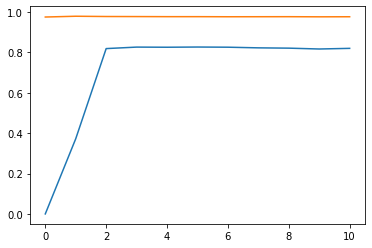

In [16]:
cb2=CustomCallback2()
accB=[]
accC=[]
accB.append(nn.evaluate(taskB['data']/255.0,taskB['label'])[1])
accC.append(nn.evaluate(taskC['data']/255.0,taskC['label'])[1])
nn.fit(taskC['data']/255.0,taskC['label'],epochs=10,validation_data=(taskB['data']/255.0,taskB['label']),callbacks=[cb2])
accB+=cb2.accB
accC+=cb2.accC
plt.plot(accC)
plt.plot(accB)
plt.show()

In [17]:
nn.evaluate(taskA['data']/255,taskA['label'])

186/186 [==============================] - 0s 2ms/step - loss: 1.4179 - accuracy: 0.9759


[1.4179279804229736, 0.9758568406105042]